In [1689]:
import os
import requests
import numpy as np
import pandas as pd
from pathlib import Path
import hvplot.pandas
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pandas import to_datetime
from datetime import datetime, timezone
from prophet import Prophet
import datetime
import pytz
from dateutil import tz
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [1690]:
API_KEY = 'PK7EOWEMB2ZH224YP6FF'
SECRET_KEY = 'YhKNcSbiESqF9iAfcrt6aALO7jAZIb0y5nYpbeE2'

In [1691]:
load_dotenv()

True

# Creation of Dataset

In [1692]:
alpaca = tradeapi.REST(
    API_KEY,
    SECRET_KEY,
    api_version = "v2")

In [1693]:
start = pd.Timestamp("2017-08-22", tz= "UTC" ).isoformat()

In [1694]:
end = pd.Timestamp("2022-08-22", tz= "UTC" ).isoformat()

In [1695]:
ticker = ["BTCUSD"]

In [1696]:
timeframe = "1Day"

In [1697]:
df = alpaca.get_crypto_bars(
    ticker,
    timeframe,
    start ,
    end
).df

In [1698]:
df.head()

,exchange,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,,
2017-08-22 05:00:00+00:00,CBSE,3662.74,4145.00,3583.46,4092.00,13675.653936,39320,3934.254578,BTCUSD
2017-08-23 05:00:00+00:00,CBSE,4142.50,4218.00,4112.76,4143.27,2299.176066,8164,4159.198204,BTCUSD
2017-08-24 05:00:00+00:00,CBSE,4143.28,4349.99,4134.61,4312.03,7921.954295,31051,4231.990112,BTCUSD
2017-08-25 05:00:00+00:00,CBSE,4325.01,4453.90,4284.01,4360.00,8711.254435,30231,4368.579716,BTCUSD
2017-08-26 05:00:00+00:00,CBSE,4344.32,4392.00,4320.84,4326.00,1588.006506,7440,4350.164046,BTCUSD


In [1699]:
df = df.drop(columns = ["exchange","open","high","low","volume","trade_count","vwap","symbol"])

In [1700]:
df.head()

,close
timestamp,
2017-08-22 05:00:00+00:00,4092.00
2017-08-23 05:00:00+00:00,4143.27
2017-08-24 05:00:00+00:00,4312.03
2017-08-25 05:00:00+00:00,4360.00
2017-08-26 05:00:00+00:00,4326.00


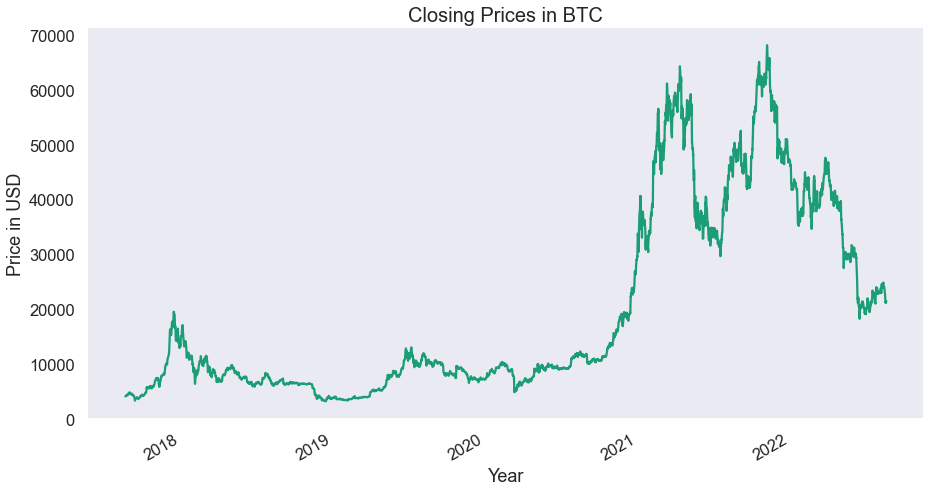

In [1701]:
df['close'].plot(figsize = (15, 8))
plt.grid()
plt.xlabel("Year")
plt.ylabel("Price in USD")
plt.title('Closing Prices in BTC', fontsize = 20)
plt.show()

In [1702]:
# create 50 days moving average column
df['SLOW_EMA'] = df['close'].rolling(window = 50, min_periods = 1).mean()
# create 200 days simple moving average column
df['FAST_EMA'] = df['close'].rolling(window = 200, min_periods = 1).mean()
# display first few rows
df.head()

,close,SLOW_EMA,FAST_EMA
timestamp,,,
2017-08-22 05:00:00+00:00,4092.00,4092.000000,4092.000000
2017-08-23 05:00:00+00:00,4143.27,4117.635000,4117.635000
2017-08-24 05:00:00+00:00,4312.03,4182.433333,4182.433333
2017-08-25 05:00:00+00:00,4360.00,4226.825000,4226.825000
2017-08-26 05:00:00+00:00,4326.00,4246.660000,4246.660000


In [1703]:
df['Signal'] = 0.0
df['Signal'] = np.where(df['SLOW_EMA'] > df['FAST_EMA'], 1.0, 0.0)

In [1704]:
df['Position'] = df['Signal'].diff()

# display first few rows
df.head()

,close,SLOW_EMA,FAST_EMA,Signal,Position
timestamp,,,,,
2017-08-22 05:00:00+00:00,4092.00,4092.000000,4092.000000,0.0,NaN
2017-08-23 05:00:00+00:00,4143.27,4117.635000,4117.635000,0.0,0.0
2017-08-24 05:00:00+00:00,4312.03,4182.433333,4182.433333,0.0,0.0
2017-08-25 05:00:00+00:00,4360.00,4226.825000,4226.825000,0.0,0.0
2017-08-26 05:00:00+00:00,4326.00,4246.660000,4246.660000,0.0,0.0


In [1705]:
df['BULL'] = np.where(df['SLOW_EMA'] > df["FAST_EMA"], df['close'], np.NaN)
df['BEAR'] = np.where(df['SLOW_EMA'] < df["FAST_EMA"], df['close'], np.NaN)

df

,close,SLOW_EMA,FAST_EMA,Signal,Position,BULL,BEAR
timestamp,,,,,,,
2017-08-22 05:00:00+00:00,4092.00,4092.000000,4092.000000,0.0,NaN,NaN,NaN
2017-08-23 05:00:00+00:00,4143.27,4117.635000,4117.635000,0.0,0.0,NaN,NaN
2017-08-24 05:00:00+00:00,4312.03,4182.433333,4182.433333,0.0,0.0,NaN,NaN
2017-08-25 05:00:00+00:00,4360.00,4226.825000,4226.825000,0.0,0.0,NaN,NaN
2017-08-26 05:00:00+00:00,4326.00,4246.660000,4246.660000,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
2022-08-20 05:00:00+00:00,21236.10,23505.396400,21810.484150,1.0,0.0,21236.10,NaN
2022-08-20 05:00:00+00:00,21196.00,23466.170600,21806.103950,1.0,0.0,21196.00,NaN
2022-08-21 05:00:00+00:00,21468.38,23432.424200,21803.024850,1.0,0.0,21468.38,NaN


# Moving Average Considerations

In [1706]:
my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [1707]:
df_2 = df.drop(columns = ["Signal", "BEAR"])

In [1708]:
# Calculating the short-window EMA
short_rolling = df_2.rolling(window=20).mean()
short_rolling.head(20)

,close,SLOW_EMA,FAST_EMA,Position,BULL
timestamp,,,,,
2017-08-22 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-23 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-24 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-25 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-26 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-27 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-28 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-29 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-30 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN


In [1709]:
# Calculating the long-window EMA
long_rolling = df_2.rolling(window=100).mean()
long_rolling.tail()

,close,SLOW_EMA,FAST_EMA,Position,BULL
timestamp,,,,,
2022-08-20 05:00:00+00:00,23155.9009,22505.707248,23111.592766,0.01,NaN
2022-08-20 05:00:00+00:00,23149.1669,22535.020560,23081.909012,0.01,NaN
2022-08-21 05:00:00+00:00,23144.7607,22563.459068,23052.563778,0.01,NaN
2022-08-21 05:00:00+00:00,23125.5300,22590.717882,23023.478220,0.01,NaN
2022-08-21 05:00:00+00:00,23106.8950,22616.798952,22994.739399,0.01,NaN


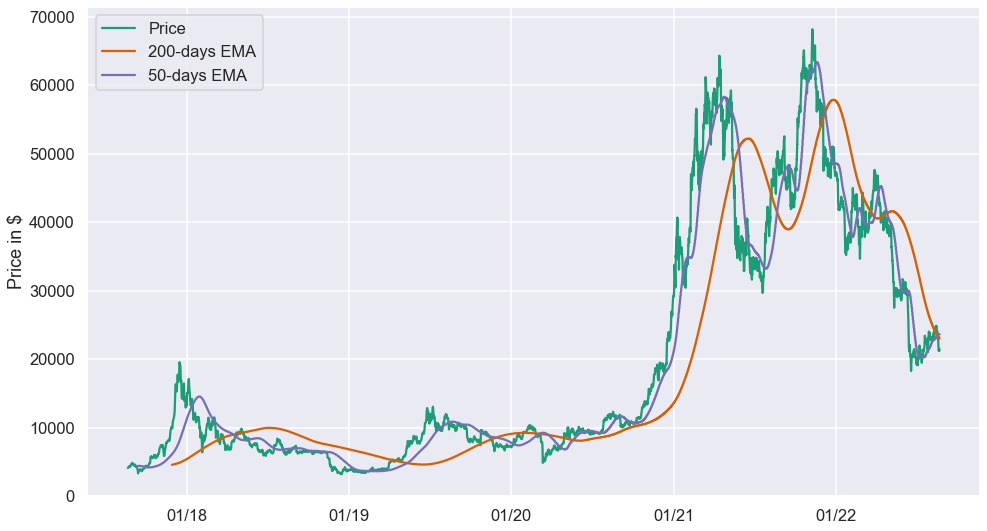

In [1710]:
start_date = '2017-08-22'
end_date = '2022-08-21'

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df_2.loc[start_date:end_date, :].index, df_2.loc[start_date:end_date, 'close'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'FAST_EMA'], label = '200-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'SLOW_EMA'], label = '50-days EMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

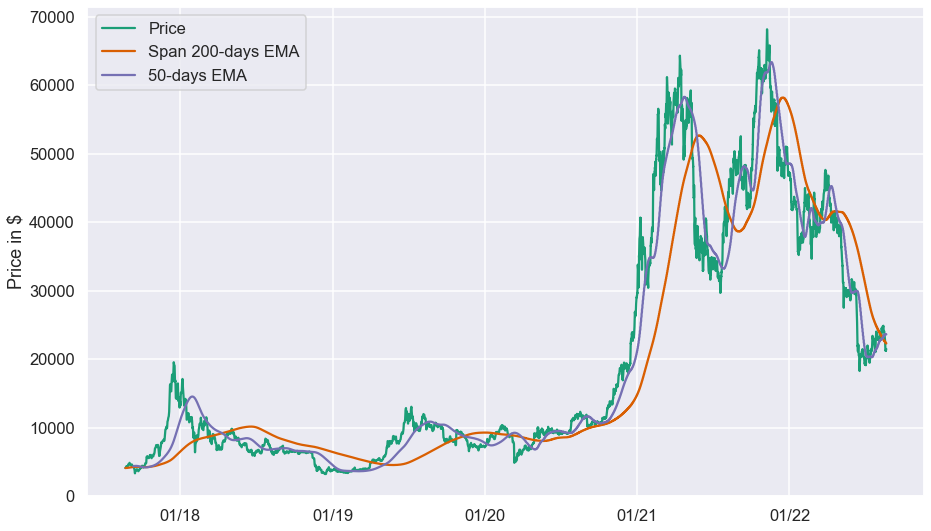

In [1739]:
# Using Pandas to calculate a 50-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = df_2.ewm(span=50, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(df_2.loc[start_date:end_date, :].index, df_2.loc[start_date:end_date, 'close'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'FAST_EMA'], label = 'Span 200-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'SLOW_EMA'], label = '50-days EMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

## A Moving Average Trading Strategy

In [1712]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = df - ema_short
trading_positions_raw.tail()

,BEAR,BULL,FAST_EMA,Position,SLOW_EMA,Signal,close
timestamp,,,,,,,
2022-08-20 05:00:00+00:00,NaN,-1472.824780,-118.190853,-0.001288,-66.247172,NaN,-1474.759764
2022-08-20 05:00:00+00:00,NaN,-1368.836706,-110.897619,-0.001165,-95.427927,NaN,-1370.587405
2022-08-21 05:00:00+00:00,NaN,-992.032258,-103.121794,-0.001054,-116.872010,NaN,-993.616224
2022-08-21 05:00:00+00:00,NaN,-896.087281,-96.137099,-0.000954,-136.231819,NaN,-897.520393
2022-08-21 05:00:00+00:00,NaN,-808.936111,-82.632718,-0.000863,-154.783246,NaN,-810.232737


In [1713]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/3
trading_positions.tail()

,BEAR,BULL,FAST_EMA,Position,SLOW_EMA,Signal,close
timestamp,,,,,,,
2022-08-20 05:00:00+00:00,NaN,-0.333333,-0.333333,-0.333333,-0.333333,NaN,-0.333333
2022-08-20 05:00:00+00:00,NaN,-0.333333,-0.333333,-0.333333,-0.333333,NaN,-0.333333
2022-08-21 05:00:00+00:00,NaN,-0.333333,-0.333333,-0.333333,-0.333333,NaN,-0.333333
2022-08-21 05:00:00+00:00,NaN,-0.333333,-0.333333,-0.333333,-0.333333,NaN,-0.333333
2022-08-21 05:00:00+00:00,NaN,-0.333333,-0.333333,-0.333333,-0.333333,NaN,-0.333333


In [1714]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

## Examine timeseries and how the respective trading position look like for BTC

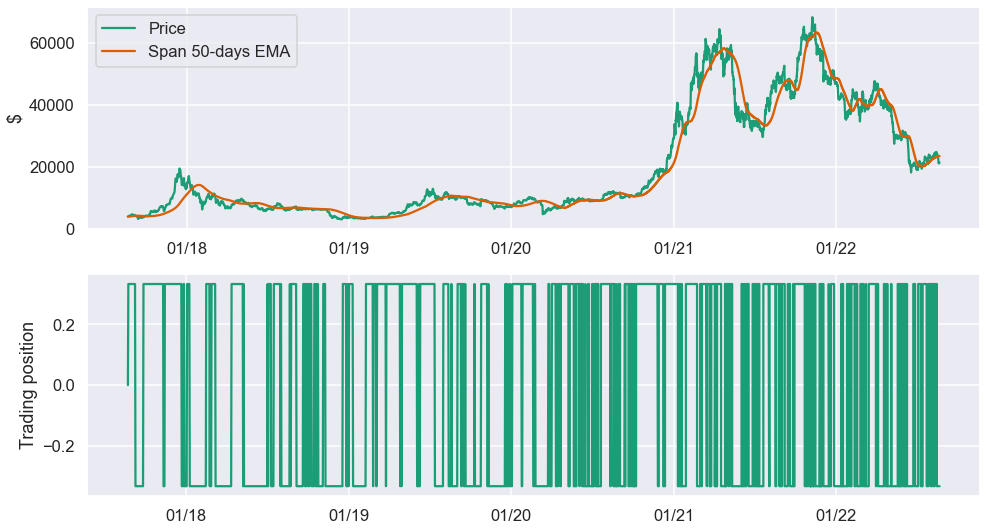

In [1715]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(df_2.loc[start_date:end_date, :].index, df_2.loc[start_date:end_date, 'close'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'SLOW_EMA'], label = 'Span 50-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'close'], 
        label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [1716]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(df_2).diff()
asset_log_returns.head()

,close,SLOW_EMA,FAST_EMA,Position,BULL
timestamp,,,,,
2017-08-22 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2017-08-23 05:00:00+00:00,0.012451,0.006245,0.006245,NaN,NaN
2017-08-24 05:00:00+00:00,0.039923,0.015614,0.015614,NaN,NaN
2017-08-25 05:00:00+00:00,0.011063,0.010558,0.010558,NaN,NaN
2017-08-26 05:00:00+00:00,-0.007829,0.004682,0.004682,NaN,NaN


In [1717]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

,BEAR,BULL,FAST_EMA,Position,SLOW_EMA,Signal,close
timestamp,,,,,,,
2022-08-20 05:00:00+00:00,NaN,-0.000565,-0.000008,NaN,0.000530,NaN,-0.000565
2022-08-20 05:00:00+00:00,NaN,0.000630,0.000067,NaN,0.000557,NaN,0.000630
2022-08-21 05:00:00+00:00,NaN,-0.004256,0.000047,NaN,0.000480,NaN,-0.004256
2022-08-21 05:00:00+00:00,NaN,-0.000025,0.000048,NaN,0.000480,NaN,-0.000025
2022-08-21 05:00:00+00:00,NaN,-0.000031,-0.000073,NaN,0.000497,NaN,-0.000031


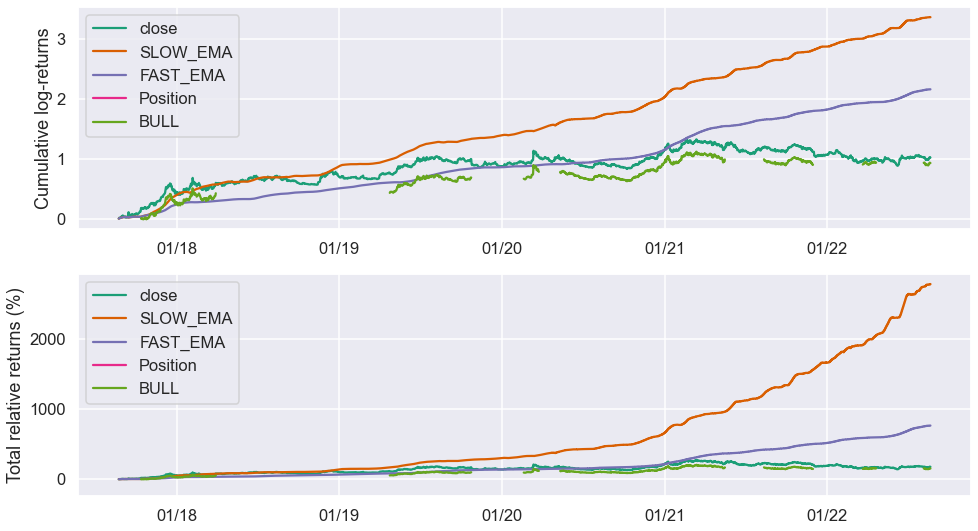

In [1718]:
# Get the cumulative log-returns
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)


for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

## What is the Total Return of the Strategy?

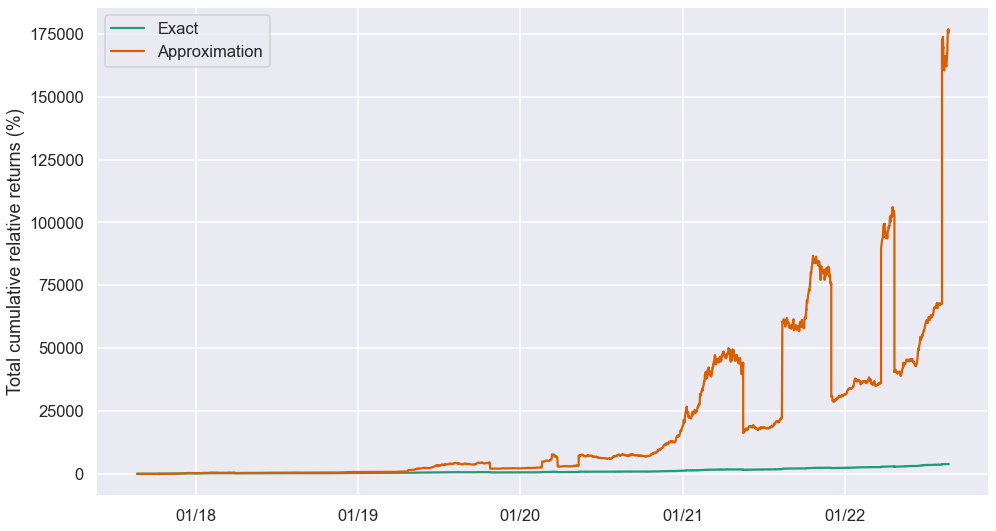

In [1719]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns 
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

## Compare Strategies:

In [1720]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: 3887.54%
Average yearly return is: 37.56%


#### One can observe that this strategy significantly overperforms the buy and hold strategy that was presented in the previous article.

Total portfolio return is: 319.97%
Average yearly return is: 13.22%


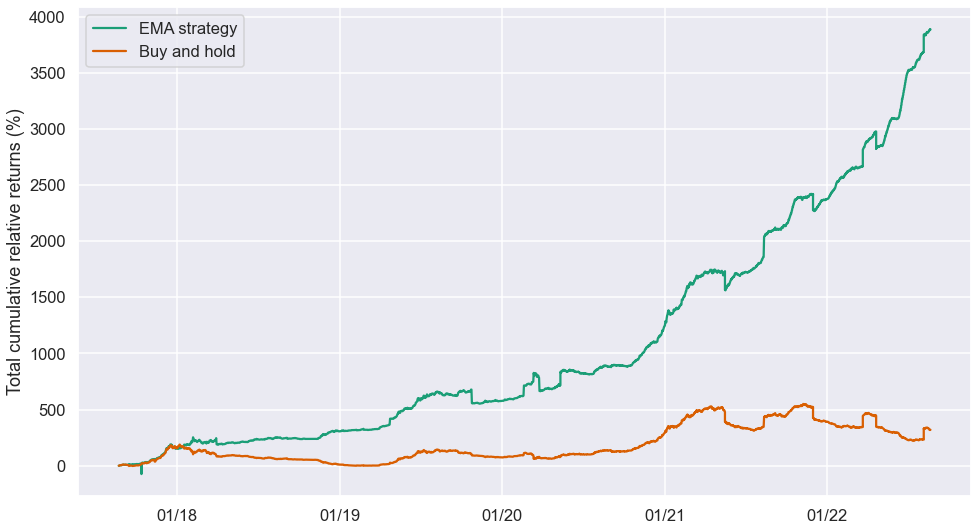

In [1721]:
# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = df.index, columns=df.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)

#### In addition, we observe in this last graph that the performance of the two strategies is not constant across time. There are some periods when one outperforms the other and other periods when it is not.

# Using Machine Learning to Predict

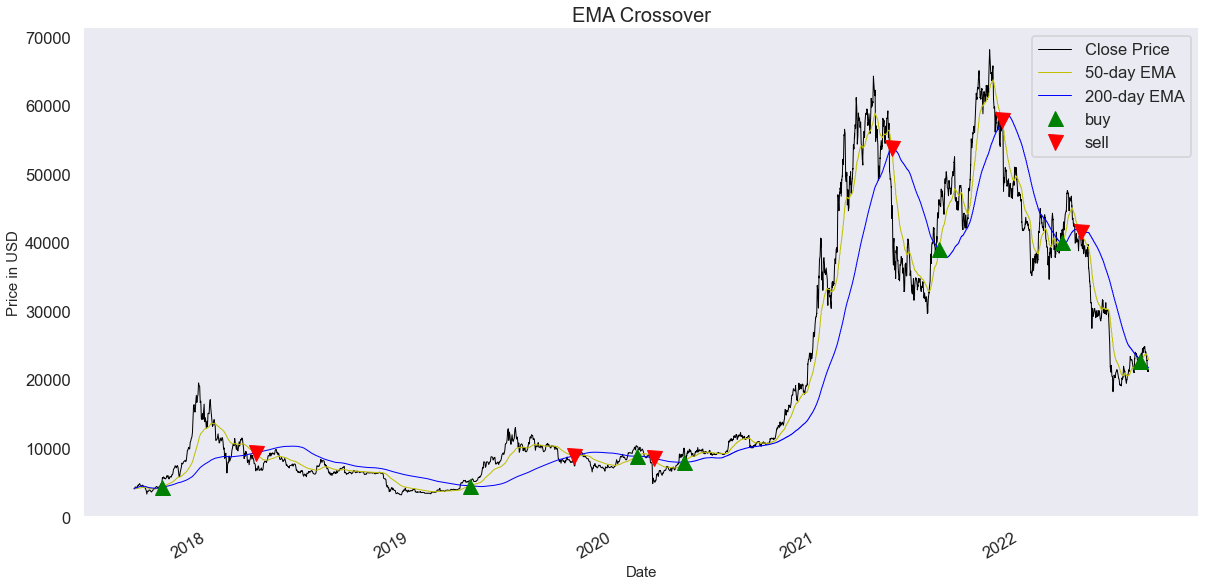

In [1722]:
# extract the daily closing price data

# Create 20 days exponential moving average column
df['SLOW_EMA'] = df['close'].ewm(span = 20, adjust = False).mean()

# Create 50 days exponential moving average column
df['SLOW_EMA'] = df['close'].ewm(span = 50, adjust = False).mean()

# create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
df['Signal'] = 0.0  
df['Signal'] = np.where(df['SLOW_EMA'] > df['FAST_EMA'], 1.0, 0.0)

# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
df['Position'] = df['Signal'].diff()
plt.figure(figsize = (20,10))

# plot close price, short-term and long-term moving averages 
df['close'].plot(color = 'k', lw = 1, label = 'Close Price')  
df['SLOW_EMA'].plot(color = 'y', lw = 1, label = '50-day EMA') 
df['FAST_EMA'].plot(color = 'b', lw = 1, label = '200-day EMA')

# plot ‘buy’ and 'sell' signals
plt.plot(df[df['Position'] == 1].index, 
         df['SLOW_EMA'][df['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
plt.plot(df[df['Position'] == -1].index, 
         df['FAST_EMA'][df['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

# Plot
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('EMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

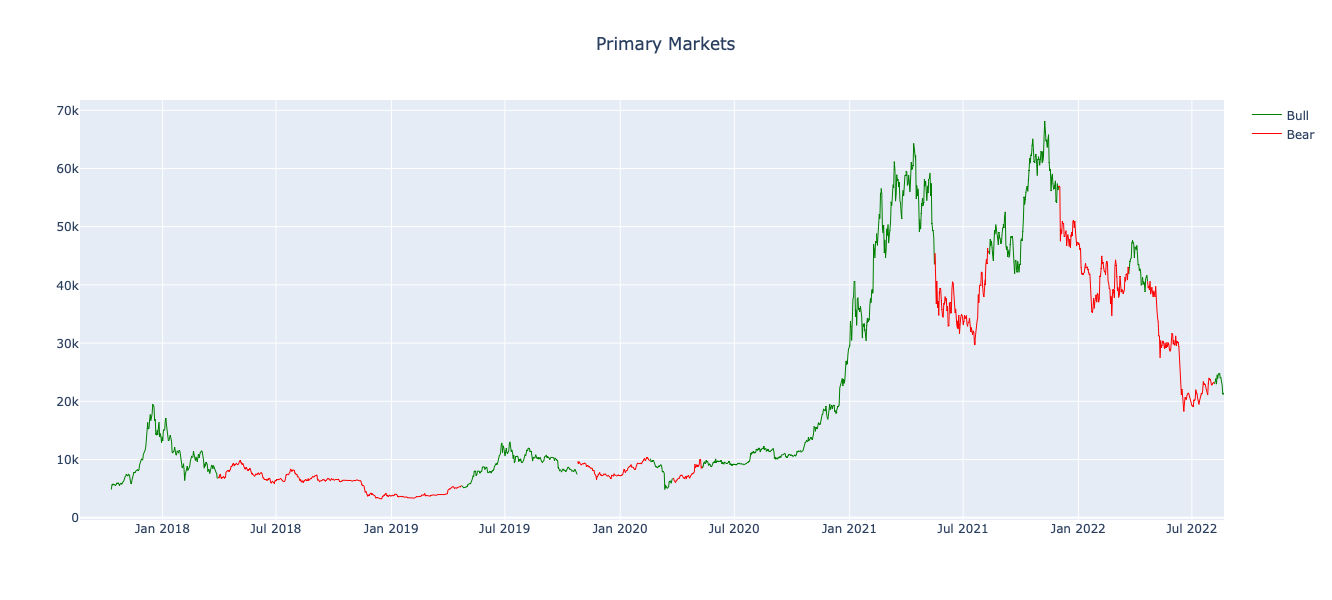

In [1723]:
# Primary Markets
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Line(x = df.index, y = df['BULL'], line=dict(color="green", width=1), name="Bull"), row = 1, col = 1)
fig.add_trace(go.Line(x = df.index, y = df['BEAR'], line=dict(color="red", width=1), name="Bear"), row = 1, col = 1)

fig.update_layout(
        title={'text':'Primary Markets', 'x':0.5},
        autosize=False,
        width=1000,height=600)
fig.update_yaxes(range=[0,1000000000],secondary_y=True)

fig.show()

In [1724]:
df = df[(df['Position'] == 1) | (df['Position'] == -1)]
df['Position'] = df['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
print(tabulate(df,tablefmt = 'psql', headers = 'keys'))

+---------------------------+----------+------------+------------+----------+------------+----------+----------+
| timestamp                 |    close |   SLOW_EMA |   FAST_EMA |   Signal | Position   |     BULL |     BEAR |
|---------------------------+----------+------------+------------+----------+------------+----------+----------|
| 2017-10-12 05:00:00+00:00 |  5731.5  |    4292.92 |    4263.62 |        1 | Buy        |  5731.5  |   nan    |
| 2018-03-29 05:00:00+00:00 |  6704.79 |    9288.76 |    9351.81 |        0 | Sell       |  6704.79 |   nan    |
| 2019-04-18 05:00:00+00:00 |  5241.81 |    4525.02 |    4508.67 |        1 | Buy        |   nan    |  5241.81 |
| 2019-10-22 05:00:00+00:00 |  7970.36 |    8825.69 |    8872.68 |        0 | Sell       |  7970.36 |   nan    |
| 2020-02-12 06:00:00+00:00 | 10351.1  |    8857.91 |    8856.04 |        1 | Buy        |   nan    | 10351.1  |
| 2020-03-14 05:00:00+00:00 |  5238.33 |    8487.77 |    8568.58 |        0 | Sell       |  5238

In [1725]:
df = df.drop(columns = ["SLOW_EMA","FAST_EMA","Signal","Position","BULL", "BEAR"])

In [1726]:
df = df.reset_index()

In [1727]:
df.head()

,timestamp,close
0,2017-10-12 05:00:00+00:00,5731.50
1,2018-03-29 05:00:00+00:00,6704.79
2,2019-04-18 05:00:00+00:00,5241.81
3,2019-10-22 05:00:00+00:00,7970.36
4,2020-02-12 06:00:00+00:00,10351.13


In [1728]:
def remove_timezone(dt):
    return dt.replace(tzinfo=None)

df['timestamp'] = df['timestamp'].apply(remove_timezone)

print(df.dtypes)

timestamp    datetime64[ns]
close               float64
dtype: object


In [1729]:
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

In [1730]:
df

,ds,y
0,2017-10-12 05:00:00,5731.50
1,2018-03-29 05:00:00,6704.79
2,2019-04-18 05:00:00,5241.81
3,2019-10-22 05:00:00,7970.36
4,2020-02-12 06:00:00,10351.13
5,2020-03-14 05:00:00,5238.33
6,2020-05-07 05:00:00,10004.77
7,2021-05-16 05:00:00,43564.00
8,2021-08-09 05:00:00,45502.00
9,2021-11-30 06:00:00,56836.00


In [1731]:
# define the model
model = Prophet()
# fit the model
model.fit(df)

17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing


In [1732]:
future = list()
for i in range(1, 12):
	date = '2023-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [1733]:
future

,ds
0,2023-01-01
1,2023-02-01
2,2023-03-01
3,2023-04-01
4,2023-05-01
5,2023-06-01
6,2023-07-01
7,2023-08-01
8,2023-09-01
9,2023-10-01


In [1734]:
forecast = model.predict(future)

          ds           yhat     yhat_lower     yhat_upper
0 2023-01-01  -18583.705070  -18583.705121  -18583.705012
1 2023-02-01 -286961.230742 -286961.230812 -286961.230662
2 2023-03-01   92294.462430   92294.462344   92294.462544
3 2023-04-01   63053.107588   63053.107476   63053.107721
4 2023-05-01   44067.957324   44067.957177   44067.957498


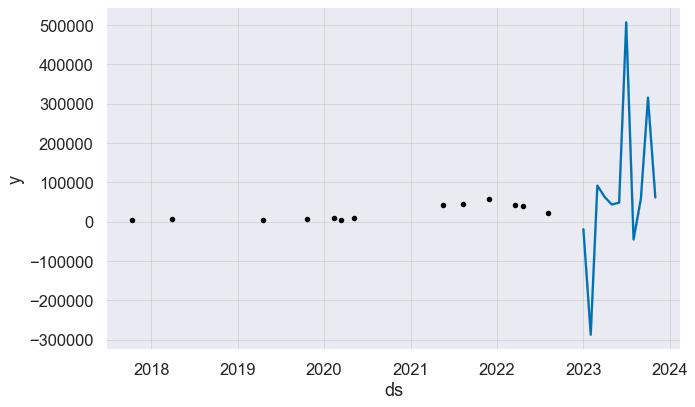

In [1735]:
# define the period for which we want a prediction
future = list()
for i in range(1, 12):
	date = '2023-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# plot forecast
model.plot(forecast)
plt.show()

In [1736]:
# create test dataset, remove last 12 months
train = df.drop(df.index[-12:])
print(train.tail())

                   ds       y
0 2017-10-12 05:00:00  5731.5


In [1737]:
# calculate MAE between expected and predicted values for december
y_true = df['y'][-11:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 126580.072


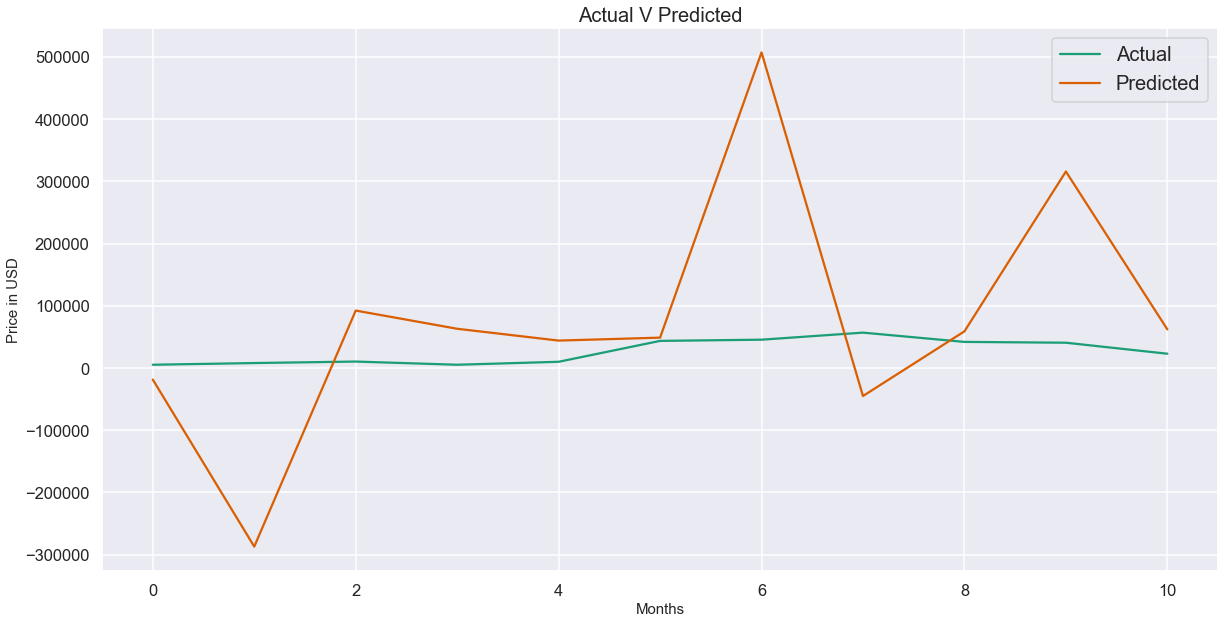

In [1738]:
# plot expected vs actual
plt.figure(figsize = (20,10))
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Months', fontsize = 15 )
plt.title('Actual V Predicted', fontsize = 20)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend(fontsize = 20)
plt.show()

#### From the findings foun through predicitions, a plot was created comparing the actual vs. predicted values. In this case, we can see that the forecast is a bad fit. The model has little skill and forecast that looks sensible. Therefore it is unjust to assume that the Actual Returns correlates to that of the Predicted Returns.